In [1]:
%cd ..

/media/Windows/Users/white/Documents/UTD/Fall19/NLP.6320.501/Project/STS-Project


In [2]:
import json

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from sts_wrldom.corpusReader import read_data
from sts_wrldom.pawarModel import pawarFit_Predict, disambiguate_pipe
from sts_wrldom.ensembleModels import ensemble_head
from sts_wrldom.utils import log_frame, accuracy, get_scores, rmse, write_results

from sts_wrldom.enrichPipe import preprocess_raw
from sts_wrldom.depTFIDFModel import depFit_Predict

In [3]:
dfs = read_data(["dev", "train"])
dev = dfs["dev"]
train = dfs["train"]

Reading dev-set from: data/dev-set.txt
Dev DF shape: (1209, 4)
Dev Pairs Omitted: 0 = 1209 - 1209

Reading train-set from: data/train-set.txt
Train DF shape: (1484, 4)
Train Pairs Omitted: 0 = 1484 - 1484



In [4]:
%%time
dev_docs = preprocess_raw(dfs["dev"])
train_docs = preprocess_raw(dfs["train"])

dev_dep_pred = depFit_Predict(dev_docs)
train_dep_pred = depFit_Predict(train_docs)

Enriching data from dataframe...
S1 parse failures: 0
S2 parse failures: 0

Enriching data from dataframe...
S1 parse failures: 0
S2 parse failures: 0

CPU times: user 27.2 s, sys: 938 ms, total: 28.1 s
Wall time: 27.9 s


In [5]:
%%time
dev_disam = disambiguate_pipe(dev, "Dev")
train_disam = disambiguate_pipe(train, "Train") 

dev_pawar_pred = pawarFit_Predict(dev_disam)
train_pawar_pred = pawarFit_Predict(train_disam)

Warming up PyWSD (takes ~10 secs)... took 8.016902208328247 secs.


Disambiguating Dev...
Disambiguating Train...
CPU times: user 1min 12s, sys: 1.36 s, total: 1min 14s
Wall time: 1min 14s


In [6]:
dev_embed_pred = list(pd.read_csv("embeds/dev_embed_predics.csv", index_col=0)["noRound"])
train_embed_pred = list(pd.read_csv("embeds/train_embed_predics.csv", index_col=0)["noRound"])

In [7]:
%%time
dev_predics = ensemble_head(dev_dep_pred, dev_pawar_pred, dev_embed_pred)
train_predics = ensemble_head(train_dep_pred, train_pawar_pred, train_embed_pred)

dev_ne_predics = ensemble_head(dev_dep_pred, dev_pawar_pred)
train_ne_predics = ensemble_head(train_dep_pred, train_pawar_pred)

CPU times: user 77.3 ms, sys: 164 µs, total: 77.5 ms
Wall time: 74.1 ms


In [8]:
dev["prediction"] = dev_predics
dev["prediction_ne"] = dev_ne_predics

train["prediction"] = train_predics
train["prediction_ne"] = train_ne_predics

In [9]:
for df, name in zip([dev, train], ["dev", "train"]):
    log_frame(df, name=name, tag="ensemble_predics")
    res = df[["id", "prediction"]]
    write_results(res, name, "ensemblePredic_all")
    res = df[["id", "prediction_ne"]]
    write_results(res, name, "ensemblePredic_ne")

for df, name in zip([dev, train], ["Dev", "Train"]):
    print(f"\n{name} Gold stats: ")
    print(pd.DataFrame(list(df["gold"]), columns=["Gold_Label"]).describe().T)
    acc = accuracy(df["prediction"], df["gold"])
    _rmse = rmse(df["prediction"], df["gold"])
    pear_corr = pearsonr(list(df["prediction"]), list(df["gold"]))
    cols = ["RMSE", "Accuracy", "Pearson's R", "Pearson's R p-val"]
    vals = [_rmse, acc, pear_corr[0], pear_corr[1]]
    stats = pd.DataFrame(list(df["prediction"]), columns=["Predic_Label"]).describe()
    extra = pd.DataFrame(vals, index=cols, columns=["Predic_Label"])
    print(f"\n{name} Ensemble Models Prediction stats: ")
    print(stats.append(extra).T)
    
    acc = accuracy(df["prediction_ne"], df["gold"])
    _rmse = rmse(df["prediction_ne"], df["gold"])
    pear_corr = pearsonr(list(df["prediction_ne"]), list(df["gold"]))
    cols = ["RMSE", "Accuracy", "Pearson's R", "Pearson's R p-val"]
    vals = [_rmse, acc, pear_corr[0], pear_corr[1]]
    stats = pd.DataFrame(list(df["prediction_ne"]), columns=["Predic_Label"]).describe()
    extra = pd.DataFrame(vals, index=cols, columns=["Predic_Label"])
    print(f"\n{name} Ensemble Models (No Embed) Prediction stats: ")
    print(stats.append(extra).T)
    print("\n------")

for df, name in zip([dev, train], ["Dev", "Train"]):
    print(f"\n{name} Prediction Metrics:")
    metrics = get_scores(list(df["prediction"]), list(df["gold"]))
    print(json.dumps(metrics, indent=2))
    
    print(f"\n{name} Prediction (No Embed) Metrics:")
    metrics = get_scores(list(df["prediction_ne"]), list(df["gold"]))
    print(json.dumps(metrics, indent=2))


Dev Gold stats: 
             count      mean       std  min  25%  50%  75%  max
Gold_Label  1209.0  3.816377  1.063869  1.0  3.0  4.0  5.0  5.0

Dev Ensemble Models Prediction stats: 
               count      mean       std  min  25%  50%  75%  max      RMSE  \
Predic_Label  1209.0  4.053763  0.437771  2.0  4.0  4.0  4.0  5.0  1.009877   

              Accuracy  Pearson's R  Pearson's R p-val  
Predic_Label  0.354012     0.385592       3.831985e-44  

Dev Ensemble Models (No Embed) Prediction stats: 
               count      mean       std  min  25%  50%  75%  max      RMSE  \
Predic_Label  1209.0  3.975186  0.676752  1.0  4.0  4.0  4.0  5.0  1.053569   

              Accuracy  Pearson's R  Pearson's R p-val  
Predic_Label   0.34574     0.350099       3.493847e-36  

------

Train Gold stats: 
             count      mean       std  min  25%  50%  75%  max
Gold_Label  1484.0  3.853774  0.999416  1.0  3.0  4.0  5.0  5.0

Train Ensemble Models Prediction stats: 
               coun

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

labels = [1, 2, 3, 4, 5]

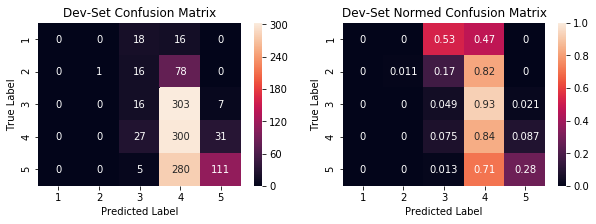

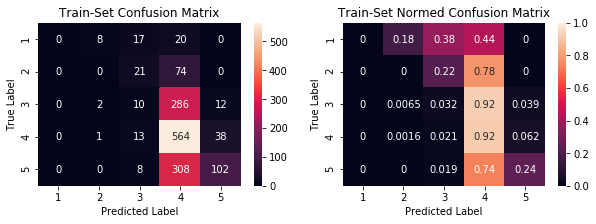

In [11]:
for df, name in zip([dev, train], ["Dev-Set", "Train-Set"]):
    cm = confusion_matrix(list(df["gold"]), list(df["prediction"]))
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    f,(ax1,ax2) = plt.subplots(1,2,sharey=False, figsize=(10,3))
    g1 = sns.heatmap(df_cm,annot=True, fmt='d', ax=ax1)
    g1.set_ylabel('True Label')
    g1.set_xlabel('Predicted Label')
    g1.set_title(f'{name} Confusion Matrix')

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm_norm = pd.DataFrame(cm_norm, index=labels, columns=labels)
    g2 = sns.heatmap(df_cm_norm,annot=True, vmin=0, vmax=1, ax=ax2)
    g2.set_ylabel('True Label')
    g2.set_xlabel('Predicted Label')
    g2.set_title(f'{name} Normed Confusion Matrix')

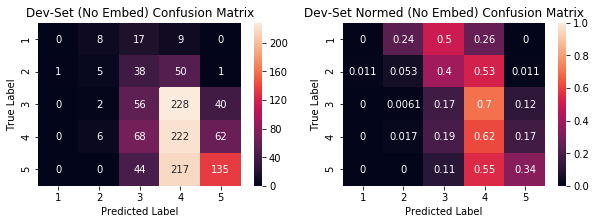

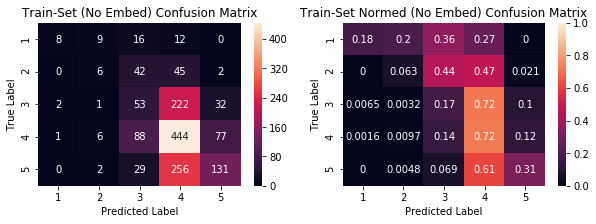

In [12]:
for df, name in zip([dev, train], ["Dev-Set", "Train-Set"]):
    cm = confusion_matrix(list(df["gold"]), list(df["prediction_ne"]))
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    f,(ax1,ax2) = plt.subplots(1,2,sharey=False, figsize=(10,3))
    g1 = sns.heatmap(df_cm,annot=True, fmt='d', ax=ax1)
    g1.set_ylabel('True Label')
    g1.set_xlabel('Predicted Label')
    g1.set_title(f'{name} (No Embed) Confusion Matrix')

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm_norm = pd.DataFrame(cm_norm, index=labels, columns=labels)
    g2 = sns.heatmap(df_cm_norm,annot=True, vmin=0, vmax=1, ax=ax2)
    g2.set_ylabel('True Label')
    g2.set_xlabel('Predicted Label')
    g2.set_title(f'{name} Normed (No Embed) Confusion Matrix')